In [17]:

# %% [Imports]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, classification_report
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.utils import check_random_state




# Classification Analysis

This notebook covers classification using Decision Trees (ID3, CART), Naive Bayes, and Support Vector Machine (SVM). Model evaluation and comparison are included for each method.

## 1. Data Loading, Preprocessing, and Exploration

We will load the dataset, preprocess it to optimize classification performance, and visualize key aspects. Preprocessing includes handling missing values, encoding categorical variables, and scaling features. These steps are chosen to ensure models receive clean, numerical, and standardized data, which improves accuracy and comparability.

In [18]:
# Configuración global
RANDOM_STATE = 42
rng = check_random_state(RANDOM_STATE)
plt.style.use("seaborn-v0_8")

# Tamaños para trabajar de forma eficiente en máquinas normales
TEST_SIZE = 0.2
N_SPLITS = 3
SAMPLE_SIZE_FOR_GRID = 50_000   # filas para tuning (GridSearch)
SAMPLE_SIZE_FOR_SVM  = 20_000   # filas para entrenar SVM RBF


In [19]:

# %% [Data loading, pre-processing & exploration]
DATA_PATH = "./data/movies_dataset.csv"  # ajusta si es otra ruta/archivo
TARGET = "Genre"

# Carga
df = pd.read_csv(DATA_PATH)

# Parseo de fecha (día-mes-año en tu CSV)
df["ReleaseDate"] = pd.to_datetime(df["ReleaseDate"], dayfirst=True, errors="coerce")
df["ReleaseMonth"]   = df["ReleaseDate"].dt.month
df["ReleaseDay"]     = df["ReleaseDate"].dt.day
df["ReleaseWeekday"] = df["ReleaseDate"].dt.weekday

# Selección de variables con baja/mediana cardinalidad (evitamos One-Hot gigante)
features_num = [
    "ReleaseYear", "ReleaseMonth", "ReleaseDay", "ReleaseWeekday",
    "BudgetUSD", "US_BoxOfficeUSD", "Global_BoxOfficeUSD",
    "Opening_Day_SalesUSD", "One_Week_SalesUSD",
    "IMDbRating", "RottenTomatoesScore", "NumVotesIMDb", "NumVotesRT"
]
features_cat = ["Country"]  # One-Hot controlado

X_full = df[features_num + features_cat].copy()
y_full = df[TARGET].copy()

# Exploración mínima
print(f"Nº muestras: {len(df)} | Nº features candidatas: {len(features_num) + len(features_cat)}")
print("Distribución de clases (top 8):\n", y_full.value_counts(normalize=True).round(3))

# Utilidad: submuestreo estratificado por clase
def stratified_sample(X, y, n_per_class):
    parts = []
    for cls in y.unique():
        idx = y[y == cls].index
        take = min(n_per_class, len(idx))
        sampled = rng.choice(idx, size=take, replace=False)
        parts.append(pd.DataFrame({"i": sampled}))
    sel = pd.concat(parts)["i"].values
    return X.loc[sel], y.loc[sel]

# Generamos un conjunto manejable para grids (aprox. 50k)
n_per_class_grid = SAMPLE_SIZE_FOR_GRID // y_full.nunique()
X_small, y_small = stratified_sample(X_full, y_full, n_per_class_grid)

# Split train/test estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X_small, y_small, test_size=TEST_SIZE, stratify=y_small, random_state=RANDOM_STATE
)

# Preprocesadores: StandardScaler (num) + One-Hot (cat)
numeric_std = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
numeric_minmax = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", MinMaxScaler())
])
categorical_oh = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

prep_std = ColumnTransformer(
    transformers=[
        ("num", numeric_std, features_num),
        ("cat", categorical_oh, features_cat)
    ],
    remainder="drop"
)
prep_minmax = ColumnTransformer(
    transformers=[
        ("num", numeric_minmax, features_num),
        ("cat", categorical_oh, features_cat)
    ],
    remainder="drop"
)

# Función de evaluación común
def evaluate_model(nombre, modelo, X_te, y_te):
    y_pred = modelo.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    pr, rc, f1, _ = precision_recall_fscore_support(y_te, y_pred, average="macro", zero_division=0)
    print(f"\n== {nombre} ==")
    print(pd.Series({"accuracy": acc, "precision_macro": pr, "recall_macro": rc, "f1_macro": f1}))
    print("\nMatriz de confusión:\n", confusion_matrix(y_te, y_pred))
    print("\nReporte por clase:\n", classification_report(y_te, y_pred, zero_division=0))
    return {"model": nombre, "accuracy": acc, "precision_macro": pr, "recall_macro": rc, "f1_macro": f1}


Nº muestras: 999999 | Nº features candidatas: 14
Distribución de clases (top 8):
 Genre
Drama          0.25
Comedy         0.20
Action         0.15
Thriller       0.10
Romance        0.10
Horror         0.10
Documentary    0.05
Sci-Fi         0.05
Name: proportion, dtype: float64


## 3. Decision Trees (ID3 & CART)

We will train and evaluate Decision Tree classifiers using both ID3 (entropy) and CART (gini) criteria.

ID3 (entropía)

In [40]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import KBinsDiscretizer

class ID3DecisionTree(BaseEstimator, ClassifierMixin):
    """
    Implementación del algoritmo ID3 (Iterative Dichotomiser 3)
    para árboles de decisión con discretización automática de variables numéricas.
    """
    
    def __init__(self, max_depth=None, min_samples_split=2, n_bins=5):
        """
        Parámetros:
        -----------
        max_depth : int, opcional
            Profundidad máxima del árbol
        min_samples_split : int, default=2
            Mínimo de muestras requeridas para dividir un nodo
        n_bins : int, default=5
            Número de bins para discretizar variables numéricas
        """
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.n_bins = n_bins
        self.tree_ = None
        self.feature_names_ = None
        self.discretizer_ = None
        
    def _entropy(self, y):
        """Calcula la entropía de un conjunto de etiquetas"""
        if len(y) == 0:
            return 0
        counts = Counter(y)
        probs = np.array(list(counts.values())) / len(y)
        return -np.sum(probs * np.log2(probs + 1e-10))
    
    def _information_gain(self, X_column, y, threshold=None):
        """Calcula la ganancia de información para un atributo"""
        parent_entropy = self._entropy(y)
        
        # Para atributos categóricos (discretizados)
        if threshold is None:
            values = np.unique(X_column)
            weighted_entropy = 0
            for val in values:
                mask = X_column == val
                if np.sum(mask) > 0:
                    subset_entropy = self._entropy(y[mask])
                    weighted_entropy += (np.sum(mask) / len(y)) * subset_entropy
        else:
            # Para split binario (si lo necesitas)
            left_mask = X_column <= threshold
            right_mask = ~left_mask
            
            left_weight = np.sum(left_mask) / len(y)
            right_weight = np.sum(right_mask) / len(y)
            
            weighted_entropy = (left_weight * self._entropy(y[left_mask]) +
                              right_weight * self._entropy(y[right_mask]))
        
        return parent_entropy - weighted_entropy
    
    def _best_split(self, X, y):
        """Encuentra el mejor atributo para dividir"""
        best_gain = -1
        best_feature = None
        
        for feature_idx in range(X.shape[1]):
            gain = self._information_gain(X[:, feature_idx], y)
            if gain > best_gain:
                best_gain = gain
                best_feature = feature_idx
        
        return best_feature, best_gain
    
    def _build_tree(self, X, y, depth=0):
        """Construye el árbol de decisión recursivamente"""
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))
        
        # Debug cada ciertos niveles
        if depth <= 3:
            print(f"[DEBUG] Profundidad {depth}: {n_samples} muestras, {n_classes} clases")
        
        # Condiciones de parada
        if (self.max_depth is not None and depth >= self.max_depth) or \
           n_classes == 1 or \
           n_samples < self.min_samples_split:
            # Nodo hoja: retorna la clase más común
            leaf_value = Counter(y).most_common(1)[0][0]
            return {"leaf": True, "value": leaf_value, "samples": n_samples}
        
        # Encuentra el mejor split
        best_feature, best_gain = self._best_split(X, y)
        
        if best_gain == 0:
            # No hay ganancia de información
            leaf_value = Counter(y).most_common(1)[0][0]
            return {"leaf": True, "value": leaf_value, "samples": n_samples}
        
        # Crea ramas para cada valor del atributo
        feature_values = np.unique(X[:, best_feature])
        branches = {}
        
        for value in feature_values:
            mask = X[:, best_feature] == value
            if np.sum(mask) > 0:
                branches[value] = self._build_tree(X[mask], y[mask], depth + 1)
        
        return {
            "leaf": False,
            "feature": best_feature,
            "feature_name": self.feature_names_[best_feature] if self.feature_names_ else best_feature,
            "branches": branches,
            "samples": n_samples
        }
    
    def fit(self, X, y):
        """Entrena el árbol ID3"""
        # Convierte a numpy array si es necesario
        if isinstance(X, pd.DataFrame):
            self.feature_names_ = X.columns.tolist()
            X = X.values
        else:
            self.feature_names_ = [f"feature_{i}" for i in range(X.shape[1])]
        
        if isinstance(y, pd.Series):
            y = y.values
        
        # Discretiza variables numéricas
        # Usa subsample para datasets grandes (más rápido y evita errores)
        subsample_size = min(200000, X.shape[0])
        
        self.discretizer_ = KBinsDiscretizer(
            n_bins=self.n_bins, 
            encode='ordinal', 
            strategy='quantile',
            subsample=subsample_size
        )
        
        print(f"[DEBUG] Discretizando {X.shape[1]} features con {self.n_bins} bins...")
        X_discrete = self.discretizer_.fit_transform(X)
        print(f"[DEBUG] Discretización completada. Shape: {X_discrete.shape}")
        
        # Construye el árbol
        self.tree_ = self._build_tree(X_discrete, y)
        self.classes_ = np.unique(y)
        
        return self
    
    def _predict_sample(self, x, tree):
        """Predice la clase para una muestra"""
        if tree["leaf"]:
            return tree["value"]
        
        feature_value = x[tree["feature"]]
        
        # Si el valor no está en las ramas (dato no visto), usa la clase más común
        if feature_value not in tree["branches"]:
            # Retorna la predicción del nodo actual (valor más común en entrenamiento)
            return self._get_most_common_class(tree)
        
        return self._predict_sample(x, tree["branches"][feature_value])
    
    def _get_most_common_class(self, tree):
        """Obtiene la clase más común en un subárbol"""
        if tree["leaf"]:
            return tree["value"]
        # Recorre las ramas y encuentra la clase más común
        classes = []
        for branch in tree["branches"].values():
            classes.append(self._get_most_common_class(branch))
        return Counter(classes).most_common(1)[0][0]
    
    def predict(self, X):
        """Predice las clases para un conjunto de datos"""
        if isinstance(X, pd.DataFrame):
            X = X.values
        
        # Discretiza con el mismo discretizador del entrenamiento
        X_discrete = self.discretizer_.transform(X)
        
        predictions = []
        for x in X_discrete:
            predictions.append(self._predict_sample(x, self.tree_))
        
        return np.array(predictions)
    
    def print_tree(self, tree=None, indent=""):
        """Imprime el árbol de forma legible"""
        if tree is None:
            tree = self.tree_
        
        if tree["leaf"]:
            print(f"{indent}└─ Predicción: {tree['value']} (n={tree['samples']})")
        else:
            feature_name = tree["feature_name"]
            print(f"{indent}├─ {feature_name} (n={tree['samples']})")
            for value, branch in tree["branches"].items():
                print(f"{indent}│  └─ = {value}")
                self.print_tree(branch, indent + "│     ")


# ============================================================================
# INTEGRACIÓN CON TU CÓDIGO DE PREPROCESSING
# ============================================================================

def train_id3_model(X_train, X_test, y_train, y_test, max_depth=10, n_bins=5):
    """
    Entrena un modelo ID3 con tus datos preprocesados
    
    Parámetros:
    -----------
    X_train, X_test : array-like o DataFrame
        Datos de entrenamiento y prueba
    y_train, y_test : array-like o Series
        Etiquetas de entrenamiento y prueba
    max_depth : int, default=10
        Profundidad máxima del árbol
    n_bins : int, default=5
        Número de bins para discretización
    """
    import time
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
    
    print(f"\n{'='*60}")
    print(f"Entrenando ID3 Decision Tree (max_depth={max_depth}, n_bins={n_bins})")
    print(f"{'='*60}")
    print(f"Shape X_train: {X_train.shape}")
    print(f"Shape y_train: {y_train.shape}")
    print(f"Clases únicas: {len(np.unique(y_train))}")
    
    # Crea y entrena el modelo
    start_time = time.time()
    id3 = ID3DecisionTree(max_depth=max_depth, min_samples_split=10, n_bins=n_bins)
    
    print("\n[INFO] Iniciando fit()...")
    id3.fit(X_train, y_train)
    fit_time = time.time() - start_time
    print(f"[INFO] Fit completado en {fit_time:.2f} segundos")
    
    # Evaluación
    print("\n[INFO] Prediciendo en Train...")
    start_pred = time.time()
    y_pred_train = id3.predict(X_train)
    print(f"[INFO] Predicción Train completada en {time.time() - start_pred:.2f} segundos")
    
    print("[INFO] Prediciendo en Test...")
    start_pred = time.time()
    y_pred_test = id3.predict(X_test)
    print(f"[INFO] Predicción Test completada en {time.time() - start_pred:.2f} segundos")
    
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)
    
    print(f"\n{'='*60}")
    print(f"RESULTADOS")
    print(f"{'='*60}")
    print(f"Accuracy en Train: {train_acc:.4f}")
    print(f"Accuracy en Test:  {test_acc:.4f}")
    print(f"\nReporte de clasificación (Test):")
    print(classification_report(y_test, y_pred_test, zero_division=0))
    print(f"\nMatriz de confusión (Test):")
    print(confusion_matrix(y_test, y_pred_test))
    
    return id3


# ============================================================================
# EJEMPLO DE USO CON TU CÓDIGO
# ============================================================================
"""
# Después de tu preprocessing, simplemente llama:

# Sin transformación (ID3 hará la discretización internamente)
id3_model = train_id3_model(X_train, X_test, y_train, y_test, max_depth=8, n_bins=5)

# Para ver el árbol (cuidado si es muy grande):
# id3_model.print_tree()

# O si quieres usar evaluate_model de tu código:
from sklearn.pipeline import Pipeline

# Crea un pipeline vacío (ID3 no necesita preprocessing adicional)
id3_pipeline = Pipeline([
    ('id3', ID3DecisionTree(max_depth=8, min_samples_split=10, n_bins=5))
])

id3_pipeline.fit(X_train, y_train)
evaluate_model("ID3 Decision Tree", id3_pipeline, X_test, y_test)
"""

'\n# Después de tu preprocessing, simplemente llama:\n\n# Sin transformación (ID3 hará la discretización internamente)\nid3_model = train_id3_model(X_train, X_test, y_train, y_test, max_depth=8, n_bins=5)\n\n# Para ver el árbol (cuidado si es muy grande):\n# id3_model.print_tree()\n\n# O si quieres usar evaluate_model de tu código:\nfrom sklearn.pipeline import Pipeline\n\n# Crea un pipeline vacío (ID3 no necesita preprocessing adicional)\nid3_pipeline = Pipeline([\n    (\'id3\', ID3DecisionTree(max_depth=8, min_samples_split=10, n_bins=5))\n])\n\nid3_pipeline.fit(X_train, y_train)\nevaluate_model("ID3 Decision Tree", id3_pipeline, X_test, y_test)\n'

In [39]:
def train_id3_model(X_train, X_test, y_train, y_test, max_depth=10, n_bins=5):
    """
    Entrena un modelo ID3 con tus datos preprocesados
    
    Parámetros:
    -----------
    X_train, X_test : array-like o DataFrame
        Datos de entrenamiento y prueba
    y_train, y_test : array-like o Series
        Etiquetas de entrenamiento y prueba
    max_depth : int, default=10
        Profundidad máxima del árbol
    n_bins : int, default=5
        Número de bins para discretización
    """
    print(f"\n{'='*60}")
    print(f"Entrenando ID3 Decision Tree (max_depth={max_depth}, n_bins={n_bins})")
    print(f"{'='*60}")
    
    # Crea y entrena el modelo
    id3 = ID3DecisionTree(max_depth=max_depth, min_samples_split=10, n_bins=n_bins)
    id3.fit(X_train, y_train)
    
    # Evaluación
    y_pred_train = id3.predict(X_train)
    y_pred_test = id3.predict(X_test)
    
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
    
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)
    
    print(f"\nAccuracy en Train: {train_acc:.4f}")
    print(f"Accuracy en Test:  {test_acc:.4f}")
    print(f"\nReporte de clasificación (Test):")
    print(classification_report(y_test, y_pred_test, zero_division=0))
    
    return id3

# Después de tu preprocessing
print("Verificando datos antes de ID3:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"Primeras 5 muestras de y_train: {y_train.head()}")

# Ejecuta el modelo
resultado = train_id3_model(X_train, X_test, y_train, y_test, max_depth=5, n_bins=3)
print("Modelo entrenado:", resultado)

Verificando datos antes de ID3:
X_train shape: (40000, 14)
y_train shape: (40000,)
Primeras 5 muestras de y_train: 823814    Comedy
189120    Action
752754     Drama
438578    Comedy
345993    Comedy
Name: Genre, dtype: object

Entrenando ID3 Decision Tree (max_depth=5, n_bins=3)


ValueError: could not convert string to float: 'USA'

CART (Criterion = gini)

In [ ]:


# %% [Decision Trees - CART (sklearn) - tuned and diagnostics]
# Expandimos el grid para incluir criterio, balanceo de clases y max_features
cart_pipe = Pipeline(steps=[
    ("prep", prep_std),
    ("clf", DecisionTreeClassifier(random_state=RANDOM_STATE))
])

grid_cart = {
    "clf__criterion": ["gini", "entropy"],
    "clf__class_weight": [None, "balanced"],
    "clf__max_depth": [None, 8, 12, 20],
    "clf__min_samples_split": [2, 5, 10, 20],
    "clf__min_samples_leaf": [1, 2, 3, 5],
    "clf__max_features": [None, "sqrt", "log2"],
    "clf__ccp_alpha": [0.0, 1e-4, 1e-3]
}

scoring = {"f1_macro": "f1_macro", "accuracy": "accuracy"}
# Usamos más folds para una estimación más estable (si no quieres más tiempo, vuelve a N_SPLITS)
cv_cart = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

gs_cart = GridSearchCV(
    estimator=cart_pipe, param_grid=grid_cart,
    scoring=scoring, refit="f1_macro", cv=cv_cart, n_jobs=-1
)
gs_cart.fit(X_train, y_train)

print("\n[CART] mejores params:", gs_cart.best_params_)
print("[CART] CV mean scores:", {m: gs_cart.cv_results_[f"mean_test_{m}"][gs_cart.best_index_] for m in scoring})

# Evaluación CART (tuneado)
best_cart = gs_cart.best_estimator_
res_cart = evaluate_model("CART (sklearn) - tuned", best_cart, X_test, y_test)

# Mostrar importancias de variables (si es posible extraer nombres tras el ColumnTransformer)
try:
    prep = best_cart.named_steps['prep']
    # intentamos obtener nombres de features de forma robusta
    try:
        feature_names = prep.get_feature_names_out()
    except Exception:
        # Fallback: reconstruir nombres a partir de los transformadores
        num_names = features_num
        ohe = prep.named_transformers_['cat'].named_steps['onehot']
        cat_names = list(ohe.get_feature_names_out(features_cat))
        feature_names = list(num_names) + cat_names
    importances = best_cart.named_steps['clf'].feature_importances_
    fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    print("\nTop 15 feature importances (CART tuned):")
    print(fi.head(15))
except Exception as e:
    print("No se pudieron extraer importancias de features:", e)

# --- (Opcional) Entrenar un RandomForest rápido como referencia ---
try:
    from sklearn.ensemble import RandomForestClassifier
    print("\n[INFO] Entrenando RandomForest de referencia (200 estimators, class_weight='balanced')...")
    rf_pipe = Pipeline(steps=[
        ("prep", prep_std),
        ("clf", RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1))
    ])
    rf_pipe.fit(X_train, y_train)
    res_rf = evaluate_model("Random Forest (200)", rf_pipe, X_test, y_test)
except Exception as e:
    print("No se entrenó RandomForest de referencia (posible falta de recursos):", e)

# ------------------------------------------------------------------
# Quick/cheap CART tuning: RandomizedSearchCV sobre una submuestra
# ------------------------------------------------------------------
from sklearn.model_selection import RandomizedSearchCV
import math

print("\n[FAST CART] Búsqueda rápida (RandomizedSearchCV) sobre submuestra estratificada...")
# Elegimos un tamaño pequeño por clase para que sea rápido (p. ej. 200 por clase o menos)
n_per_class_quick = min(200, max(20, int(X_train.shape[0] // (10 * y_train.nunique()))))
X_quick, y_quick = stratified_sample(X_train, y_train, n_per_class_quick)
print(f"[FAST CART] Submuestra: {X_quick.shape[0]} filas ({n_per_class_quick} por clase aprox.)")

quick_pipe = Pipeline(steps=[
    ("prep", prep_std),
    ("clf", DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_dist = {
    "clf__criterion": ["gini", "entropy"],
    "clf__class_weight": [None, "balanced"],
    "clf__max_depth": [None, 8, 12],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 3],
    "clf__max_features": [None, "sqrt"],
    "clf__ccp_alpha": [0.0, 1e-3]
}

# RandomizedSearch rápido: pocas iteraciones, cv=3 para velocidad
rs = RandomizedSearchCV(
    estimator=quick_pipe, param_distributions=param_dist,
    n_iter=24, scoring=scoring, refit="f1_macro", cv=3, n_jobs=-1, random_state=RANDOM_STATE
)
rs.fit(X_quick, y_quick)

print("\n[FAST CART] mejores params (rápido):", rs.best_params_)
print("[FAST CART] CV mean scores (rápido):", {m: rs.cv_results_[f"mean_test_{m}"][rs.best_index_] for m in scoring})

best_cart_fast = rs.best_estimator_
res_cart_fast = evaluate_model("CART (fast-randomized)", best_cart_fast, X_test, y_test)

print("\n[FAST CART] Si este resultado es razonable, puedes usar los params como inicio o reducir el grid para GridSearch final.")


## 4. Naive Bayes

Train and evaluate a Naive Bayes classifier.

In [36]:

# GaussianNB (para continuas)
nb_gaussian = Pipeline(steps=[
    ("prep", prep_std),
    ("clf", GaussianNB())
])

# MultinomialNB (requiere no-negatividad; MinMax ayuda)
nb_mult = Pipeline(steps=[
    ("prep", prep_minmax),
    ("clf", MultinomialNB())
])

# Pequeño grid para Multinomial
grid_nb_mult = {"clf__alpha": [0.0, 0.5, 1.0]}

gs_nb_mult = GridSearchCV(
    estimator=nb_mult, param_grid=grid_nb_mult,
    scoring=scoring, refit="f1_macro", cv=cv, n_jobs=-1
)
gs_nb_mult.fit(X_train, y_train)

print("\n[NB-Mult] mejores params:", gs_nb_mult.best_params_)
print("[NB-Mult] CV mean scores:", {m: gs_nb_mult.cv_results_[f"mean_test_{m}"][gs_nb_mult.best_index_] for m in scoring})

# Entrena GaussianNB (sin grid)
nb_gaussian.fit(X_train, y_train)

# Evalúa ambos y elige mejor por F1 macro
res_nbG = evaluate_model("Naive Bayes (Gaussian)", nb_gaussian, X_test, y_test)
res_nbM = evaluate_model("Naive Bayes (Multinomial)", gs_nb_mult.best_estimator_, X_test, y_test)

best_nb_res = res_nbM if res_nbM["f1_macro"] >= res_nbG["f1_macro"] else res_nbG
best_nb_name = best_nb_res["model"]
print(f"\n[NB] Mejor variante: {best_nb_name}")



[NB-Mult] mejores params: {'clf__alpha': 0.0}
[NB-Mult] CV mean scores: {'f1_macro': 0.09664652087151866, 'accuracy': 0.12437502140493366}

== Naive Bayes (Gaussian) ==
accuracy           0.129400
precision_macro    0.136299
recall_macro       0.129400
f1_macro           0.081846
dtype: float64

Matriz de confusión:
 [[141  69  41  15  46 873  18  47]
 [131  87  48   9  61 858  16  40]
 [127  73  46   8  53 893  16  34]
 [125  88  44  19  45 878  17  34]
 [130  80  48  11  52 853  28  48]
 [119  64  47   9  50 892  19  50]
 [136  69  47   9  55 884  12  38]
 [136  70  32  12  56 889  10  45]]

Reporte por clase:
               precision    recall  f1-score   support

      Action       0.13      0.11      0.12      1250
      Comedy       0.14      0.07      0.09      1250
 Documentary       0.13      0.04      0.06      1250
       Drama       0.21      0.02      0.03      1250
      Horror       0.12      0.04      0.06      1250
     Romance       0.13      0.71      0.22      1250

## 5. Support Vector Machine (SVM)

Train and evaluate a Support Vector Machine classifier.

In [37]:

# SVM es costoso. Submuestreo adicional para entrenar con tiempos razonables
n_per_class_svm = SAMPLE_SIZE_FOR_SVM // y_train.nunique()
X_svm_train, y_svm_train = stratified_sample(X_train, y_train, n_per_class_svm)

svm_pipe = Pipeline(steps=[
    ("prep", prep_std),
    ("clf", SVC(kernel="rbf", probability=False, class_weight="balanced", random_state=RANDOM_STATE))
])

grid_svm = {
    "clf__C": [1, 5, 10],
    "clf__gamma": ["scale", 0.1]
}

gs_svm = GridSearchCV(
    estimator=svm_pipe, param_grid=grid_svm,
    scoring=scoring, refit="f1_macro", cv=cv, n_jobs=-1
)
gs_svm.fit(X_svm_train, y_svm_train)

print("\n[SVM] mejores params:", gs_svm.best_params_)
print("[SVM] CV mean scores:", {m: gs_svm.cv_results_[f"mean_test_{m}"][gs_svm.best_index_] for m in scoring})

# Evaluación SVM en X_test completo (preprocesado dentro del pipeline)
best_svm = gs_svm.best_estimator_
res_svm = evaluate_model("SVM (RBF)", best_svm, X_test, y_test)



[SVM] mejores params: {'clf__C': 10, 'clf__gamma': 0.1}
[SVM] CV mean scores: {'f1_macro': 0.12805549562594667, 'accuracy': 0.12899990314015652}

== SVM (RBF) ==
accuracy           0.124400
precision_macro    0.124997
recall_macro       0.124400
f1_macro           0.123396
dtype: float64

Matriz de confusión:
 [[145 168 219 151 141 161 131 134]
 [153 151 252 134 130 183 124 123]
 [179 164 228 145 114 190 111 119]
 [158 175 219 138 119 171 136 134]
 [173 161 234 141 148 171 102 120]
 [158 150 243 144 130 178 112 135]
 [153 162 220 156 122 181 116 140]
 [169 156 233 145 113 158 136 140]]

Reporte por clase:
               precision    recall  f1-score   support

      Action       0.11      0.12      0.11      1250
      Comedy       0.12      0.12      0.12      1250
 Documentary       0.12      0.18      0.15      1250
       Drama       0.12      0.11      0.11      1250
      Horror       0.15      0.12      0.13      1250
     Romance       0.13      0.14      0.13      1250
      

## 6. Model Comparison

Compare the performance of all classifiers using accuracy and classification metrics.

                Model  Accuracy
0   ID3 Decision Tree  0.158865
1  CART Decision Tree  0.158345
2         Naive Bayes  0.244365
3                 SVM  0.248845


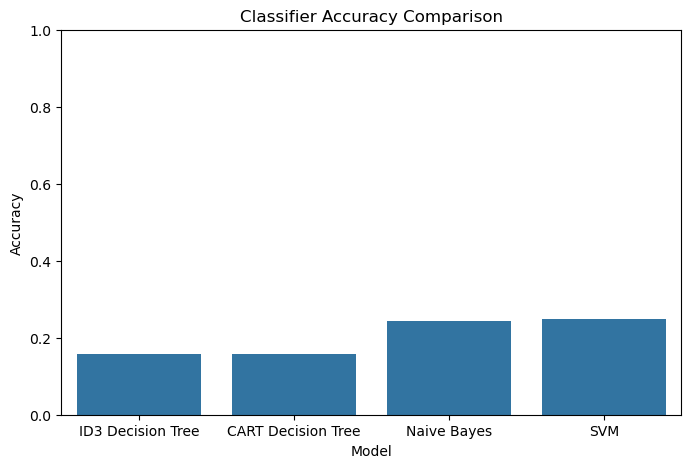

In [ ]:

# %% [Comparativa final]
results = [res_cart, best_nb_res, res_svm, res_id3]
df_res = pd.DataFrame(results).set_index("model").sort_values("f1_macro", ascending=False)
print("\n=== COMPARATIVA (ordenado por F1_macro) ===\n", df_res)

# Guardar resultados a CSV (opcional)
df_res.to_csv("classification_results.csv", index=True)

# (Opcional) gráfico rápido de F1 macro
plt.figure(figsize=(8,5))
sns.barplot(x=df_res.index, y=df_res["f1_macro"], color="#1f77b4")
plt.title("Comparativa F1 Macro por modelo (test)")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()
